In [10]:
import warnings 
warnings.filterwarnings('ignore')
import torch 
import torch.nn as nn 
import torchvision 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
from tqdm import tqdm 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,Dataset
import os 
import yaml 
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from src import Convolution_Auto_Encoder, Mnist_Dataset,MVtecADDataset,Datadir_init
from src import MVtecEncoder,MVtecDecoder,Convolution_Auto_Encoder


In [11]:
cfg = yaml.load(open('./Save_models/MVtecAD4/config.yaml','r'), Loader=yaml.FullLoader)

# 데이터 로드 

In [12]:
def preprocess(cfg,augmentation=None):
    #mk save dir 
    try:
        os.mkdir(f"./Save_models/{cfg['save_dir']}")
    except:
        pass
    torch.manual_seed(cfg['seed'])
    data_dir = cfg['Dataset_dir']
    Data_dir = Datadir_init()
    train_dirs = Data_dir.train_load()
    test_dirs,test_labels = Data_dir.test_load()

    train_dset = MVtecADDataset(cfg,train_dirs,Augmentation=augmentation)
    test_dset = MVtecADDataset(cfg,test_dirs,test_labels,Augmentation=augmentation)

    train_loader = DataLoader(train_dset,batch_size=cfg['batch_size'],shuffle=True)
    test_loader = DataLoader(test_dset,batch_size=cfg['batch_size'],shuffle=False)
    return train_loader,test_loader 

# Test data Inference 

In [13]:
#변수 리스트 
Pred_imgs = [] 
True_imgs = [] 
True_labels = [] 

#데이터 및 모델 로드 
train_loader,test_loader  = preprocess(cfg)    
model = torch.load(f"./Save_models/{cfg['save_dir']}/best.pt").to(cfg['device'])
#Inference 
for img,label in test_loader:
    img = img.to(cfg['device']).type(torch.float32)
    
    with torch.no_grad():
        Pred_img =  model(img)
        
    Pred_imgs.extend(Pred_img.detach().cpu().numpy())
    True_imgs.extend(img.detach().cpu().numpy())
    True_labels.extend(label.detach().numpy())
    
Pred_imgs = np.array(Pred_imgs)
True_imgs = np.array(True_imgs)
True_labels = np.array(True_labels)
True_labels = np.where(True_labels==0,True_labels,1) # Anomaly:1, normal:0 

# Metrics : AUROC, ROC curve 

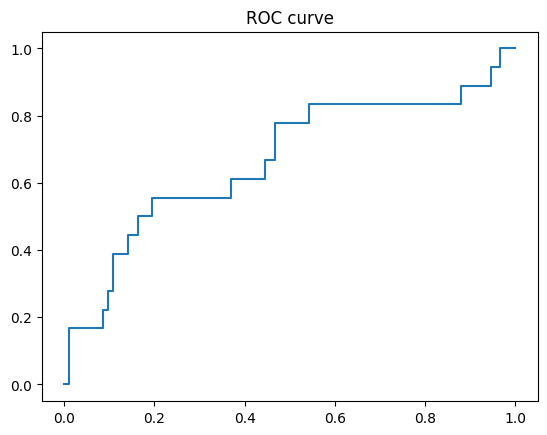

				 AUROC : 0.6655


In [29]:
def Metric_auroc_roc(Pred_imgs,True_imgs,True_labels):
    #roc_curve & AUROC 
    test_score = np.mean(np.array(Pred_imgs-True_imgs).reshape(len(True_labels),-1)**2,axis=1)
    fpr,tpr,threshold = roc_curve(True_labels,test_score,pos_label=0)
    AUROC = round(auc(fpr, tpr),4)
    plt.plot(fpr,tpr)
    plt.title('ROC curve')
    plt.show()
    return AUROC,test_score,[fpr,tpr,threshold]

auroc,test_score,roc = Metric_auroc_roc(Pred_imgs,True_imgs,True_labels)
print(f'\t\t\t\t AUROC : {auroc}')

# Metrics : F1-score

Train 데이터의 Reconstruction error와 Test 데이터의 Reconstruction error를 비교해서 Threshold 결정 

## Train Reconstruction -> Threshold 결정 

In [33]:
#변수 리스트 
Train_Pred_imgs = [] 
Train_True_imgs = [] 
Train_True_labels = [] 

#데이터 및 모델 로드 
train_loader,test_loader  = preprocess(cfg)    
model = torch.load(f"./Save_models/{cfg['save_dir']}/best.pt").to(cfg['device'])
#Inference 
for img,label in train_loader:
    img = img.to(cfg['device']).type(torch.float32)
    
    with torch.no_grad():
        Pred_img =  model(img)
        
    Train_Pred_imgs.extend(Pred_img.detach().cpu().numpy())
    Train_True_imgs.extend(img.detach().cpu().numpy())
    Train_True_labels.extend(label.detach().numpy())
    
Train_Pred_imgs = np.array(Train_Pred_imgs)
Train_True_imgs = np.array(Train_True_imgs)
Train_True_labels = np.array(Train_True_labels)
Train_True_labels = np.where(Train_True_labels==0,Train_True_labels,1) # Anomaly:1, normal:0 

In [37]:
Train_score = np.mean(np.array(Train_Pred_imgs-Train_True_imgs).reshape(len(Train_True_labels),-1)**2,axis=1)

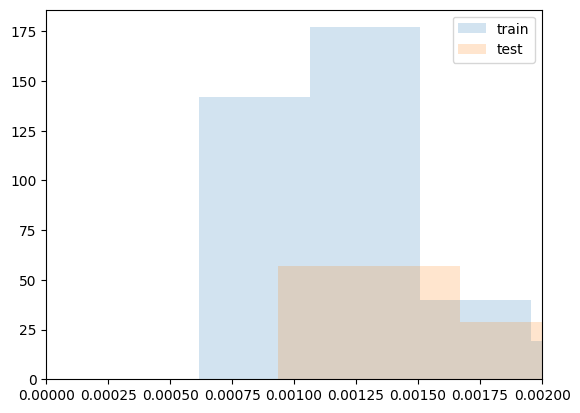

In [43]:
plt.hist(Train_score,alpha=0.2,label='train')
plt.hist(test_score,alpha=0.2,label='test')
plt.xlim(0,0.002)
plt.legend()
plt.show()

## 최종 Metric 

In [54]:
Threshold = 0.0015 
test_score> Threshold
Pred_labels = np.where(test_score> Threshold,True_labels,0)
score = classification_report(True_labels,Pred_labels)
print(score)
#print(f' F1-score : {score}')

              precision    recall  f1-score   support

           0       0.30      1.00      0.46        18
           1       1.00      0.54      0.70        92

    accuracy                           0.62       110
   macro avg       0.65      0.77      0.58       110
weighted avg       0.89      0.62      0.66       110

